# Z3 Solver Project Demo
Presentation purposes

*Svolto per la presentazione del progetto all'orale*

In [1]:
import pandas as pd 
import numpy as np 
import itertools 
from model import TimetableScheduler
from z3 import *

## Scenario 1: Toy Model
Simple model containing just a few sessions and courses, not intended to be realistic in any way

*Modello semplice che contiene qualche sessione e corsi, inteso solo per motivi di testing*

Corsi:
- Maths 101
    - Sessioni: 2, 2
    - Tenuto dal prof. John Smith
    - Frequentato dalle classi 1, 3
- Intro. to Wizardry
    - Sessioni: 3, 1
    - Tenuto dal prof. John Smith
    - Frequentata dalla classe 2
- Reading 102
    - Sessioni: 1, 2
    - Tenuto dal prof. Andrea Garfields
    - Frequentata dalla classe 1
- Musical Analysis
    - Sessioni: 2, 5
    - Tenuto dal prof. John Doe
    - Frequentata dalle classi 2, 3
- Advanced English
    - Sessioni: 2
    - Tenuto dal prof. Andrea Garfields
    - Frequentata dalla classe 1
- Tennis
    - Sessioni: 1
    - Tenuto dal prof. Jane Doe
    - Frequentata dalla classe 2

Aule:
- Una aula grande (200 persone)
- Una aula media (100 persone)
- Una aula piccola (50 persone)
- Una aula piccolissima (10 persone)

In [2]:
toy_schedule = TimetableScheduler('sample_1', 5)

In [3]:
toy_schedule.start()

In [4]:
toy_schedule.add_constraints()

In [5]:
toy_schedule.solve()

TIME TABLE SUCCESSFULLY CREATED
Saving the schedule in the SQL Database...
Schedule saved


In [6]:
names = toy_schedule.database.get_names()

In [7]:
timetable = []
for t in toy_schedule.T:
    t_slots = []

    for (S, A) in itertools.product(toy_schedule.indexes['Sessions'], toy_schedule.indexes['Rooms']):
        S_c = toy_schedule.database.get_course(S)
        if toy_schedule.model.evaluate(toy_schedule.X[S,t,A], model_completion=True):
            t_slots.append(f"{names['Courses'][toy_schedule.database.get_course(S)]} [{names['Rooms'][A]}]")
                
    if t_slots == []:
        t_slots = ["NESSUNA LEZIONE"]
    timetable.append(" > " + "\n> ".join(t_slots))

In [8]:
rows = ["11:00-12:00","12:00-13:00","13:00-14:00","14:00-15:00","15:00-16:00"]
columns = ["Lunedì", "Martedì", "Mercoledì", "Giovedì", "Venerdì", "Sabato"]

In [9]:
np_timetable = np.array(timetable, dtype=object)
np_timetable = np_timetable.reshape(6,5)

In [10]:
df = pd.DataFrame(np_timetable, columns=rows, index=columns)

In [ ]:
from IPython.display import display, HTML
display(HTML(df.T.to_html().replace("\\n", "<br>")))

,Lunedì,Martedì,Mercoledì,Giovedì,Venerdì,Sabato
11:00-12:00,> Musical Analysis [Medium Room],> Introduction to Wizardry [Small Room],> Maths 101 [Big Room]> Tennis 101 [Small Room],> NESSUNA LEZIONE,> NESSUNA LEZIONE,> NESSUNA LEZIONE
12:00-13:00,> Musical Analysis [Medium Room],> Introduction to Wizardry [Small Room],> Maths 101 [Big Room],> Reading 102 [Medium Room],> NESSUNA LEZIONE,> Reading 102 [Big Room]
13:00-14:00,> Musical Analysis [Medium Room],> Introduction to Wizardry [Small Room],> Maths 101 [Big Room],> Reading 102 [Medium Room],> NESSUNA LEZIONE,> NESSUNA LEZIONE
14:00-15:00,> Musical Analysis [Medium Room],> Musical Analysis [Medium Room],> Maths 101 [Big Room],> Advanced English [Small Room],> NESSUNA LEZIONE,> NESSUNA LEZIONE
15:00-16:00,> Musical Analysis [Medium Room],> Musical Analysis [Medium Room],> NESSUNA LEZIONE,> Advanced English [Small Room],> NESSUNA LEZIONE,> NESSUNA LEZIONE


In [12]:
toy_schedule.end()

## Scenario 2: Next Semester's Courses for AIDA
Simplified model containing (estimated) sessions and courses for the next semester in AIDA.

*Modello semplificato che contiene i corsi del prossimo semestre del CdS triennale in IADA (2025-2026, Primo Semestre)*

Vincoli aggiuntivi: 
- Non ci sono lezioni il sabato
$$
\forall S, T, A, \text{ s.t. }T\text{ rappresenta un'ora in sabato }(\lfloor T/6 \rfloor = 6), X_{S,T,A} \implies \text{False}
$$

- Gli studenti del 1°, 2° e del 3° anno hanno orari di pranzo diversi per evitare il sovraffollamento delle mense (2°, 3° sono raggruppati assieme per semplicità). Ovvero, a loro si garantiscono delle "ore vuote" per pranzare che sono diverse a seconda dell'anno.
    - Si suppone che tramite un sondaggio si è deciso che quelli del 1° anno pranzano alle 12-13 e quelli del 2°, 3° anno alle 13-14

$$
\bigvee_{\begin{gather*}S,T,V\\ \tiny{T \text{ rappresenta una fascia oraria dalle 12-13}}, \\ \tiny{S\text{ è una sessione di un corso del 1° anno}}\end{gather*}} \neg X_{S,T,V}
$$

e

$$
\bigvee_{\begin{gather*}S,T,V\\ \tiny{T \text{ rappresenta una fascia oraria dalle 13-14}}, \\ \tiny{S\text{ è una sessione di un corso del 2° e del 3° anno}}\end{gather*}} \neg X_{S,T,V}
$$

In [13]:
orario_aida = TimetableScheduler('aida', 9)

In [14]:
orario_aida.start()

In [15]:
from z3 import Not

In [16]:
# add custom constraint: no lezioni il sabato
for (S,T,A) in itertools.product(orario_aida.indexes['Sessions'],
                                 orario_aida.T,
                                 orario_aida.indexes['Rooms']):
    if (T // 9) == (6-1):
        orario_aida.solver.add(Not(orario_aida.X[S,T,A]))


In [17]:
# add custom constraint: turnazione delle mense
# osserviamo che i numeri 3, 4 rappresentano le fasce orarie 12-13 e 13-14 del lunedì. Se le sommiamo ad un multiplo di 9 otteniamo la stessa fascia oraria, riferita ad un altro giorno.
courses_1 = orario_aida.database.get_courses(1)
courses_2 = orario_aida.database.get_courses(2)
courses_3 = orario_aida.database.get_courses(3)

i = 3
while i < max(orario_aida.T):
    for course in courses_1:
        orario_aida.solver.add(And([
            Not(orario_aida.X[S,i, A]) for (S,A) in itertools.product(orario_aida.database.get_sessions(course), orario_aida.indexes['Rooms'])
        ]))

    i += 9

i = 4
while i < max(orario_aida.T):
    for course in courses_2:
        orario_aida.solver.add(And([
            Not(orario_aida.X[S,i, A]) for (S,A) in itertools.product(orario_aida.database.get_sessions(course), orario_aida.indexes['Rooms'])
        ]))

    for course in courses_3:
        orario_aida.solver.add(And([
            Not(orario_aida.X[S,i, A]) for (S,A) in itertools.product(orario_aida.database.get_sessions(course), orario_aida.indexes['Rooms'])
        ]))

    i += 9

In [18]:
orario_aida.add_constraints()

In [19]:

orario_aida.solve()

TIME TABLE SUCCESSFULLY CREATED
Saving the schedule in the SQL Database...
Schedule saved


In [20]:
# stampa l'orario per AIDA
names = orario_aida.database.get_names()
aida_timeslots = []

for t in orario_aida.T:
    t_slots = []

    for (S, A) in itertools.product(orario_aida.indexes['Sessions'], orario_aida.indexes['Rooms']):
        S_c = orario_aida.database.get_course(S)
        if orario_aida.model.evaluate(orario_aida.X[S,t,A], model_completion=True):
            t_slots.append(f"{names['Courses'][orario_aida.database.get_course(S)]} [{names['Rooms'][A]}]")
                
    if t_slots == []:
        t_slots = ['NESSUNA LEZIONE']
    aida_timeslots.append(" > " + "\n > ".join(t_slots))

In [21]:
rows = ["09:00-10:00","10:00-11:00","11:00-12:00","12:00-13:00","13:00-14:00","14:00-15:00","15:00-16:00","16:00-17:00","17:00-18:00"]
columns = ["Lunedì", "Martedì", "Mercoledì", "Giovedì", "Venerdì", "Sabato"]

np_aida_timetable = np.array(aida_timeslots, dtype=object)
np_aida_timetable = np_aida_timetable.reshape(6,9)
df = pd.DataFrame(np_aida_timetable, columns=rows, index=columns)

In [ ]:
from IPython.display import display, HTML 
display(HTML(df.T.to_html().replace("\\n", "<br>")))

,Lunedì,Martedì,Mercoledì,Giovedì,Venerdì,Sabato
09:00-10:00,"> ALGEBRA LINEARE ED ELEMENTI DI GEOMETRIA [H3, 1A] > INTRODUZIONE ALL INTELLIGENZA ARTIFICIALE [H3, 2A]","> ALGEBRA LINEARE ED ELEMENTI DI GEOMETRIA [H2 Bis, 2A MORIN] > COMPUTABILITà, COMPLESSITà E LOGICA [H3, 2C]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 1A] > INFERENZA STATISTICA [H2 Bis, 3B]","> PROGRAMMAZIONE AVANZATA E PARALLELA [H3, 1B]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 2B] > ALGORITMI E STRUTTURE DATI [H3, 2A]",> NESSUNA LEZIONE
10:00-11:00,"> ALGEBRA LINEARE ED ELEMENTI DI GEOMETRIA [H3, 1A] > INTRODUZIONE ALL INTELLIGENZA ARTIFICIALE [H3, 2A]","> ALGEBRA LINEARE ED ELEMENTI DI GEOMETRIA [H2 Bis, 2A MORIN] > COMPUTABILITà, COMPLESSITà E LOGICA [H3, 2C] > SISTEMI COMPLESSI [H3, 1A]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 1A] > INFERENZA STATISTICA [H2 Bis, 3B]","> ANALISI 1 [H3, 2A] > PROGRAMMAZIONE AVANZATA E PARALLELA [H3, 1B]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 2B] > ALGORITMI E STRUTTURE DATI [H3, 2A]",> NESSUNA LEZIONE
11:00-12:00,"> COMPUTABILITà, COMPLESSITà E LOGICA [H2 Bis, 2A MORIN] > INTRODUZIONE ALL INTELLIGENZA ARTIFICIALE [H3, 2A]","> COMPUTABILITà, COMPLESSITà E LOGICA [H2 Bis, 2A MORIN] > SISTEMI COMPLESSI [H3, 1A]","> PROGRAMMAZIONE AVANZATA E PARALLELA [H3, 1C]","> ANALISI 1 [H3, 2A] > INTRODUZIONE ALL INTELLIGENZA ARTIFICIALE [H3, 1B]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 2B] > INFERENZA STATISTICA [H2 Bis, 2A MORIN]",> NESSUNA LEZIONE
12:00-13:00,"> COMPUTABILITà, COMPLESSITà E LOGICA [H2 Bis, 2A MORIN]","> COMPUTABILITà, COMPLESSITà E LOGICA [H2 Bis, 2A MORIN]","> PROGRAMMAZIONE AVANZATA E PARALLELA [H3, 1C]","> INTRODUZIONE ALL INTELLIGENZA ARTIFICIALE [H3, 1B]","> INFERENZA STATISTICA [H2 Bis, 2A MORIN]",> NESSUNA LEZIONE
13:00-14:00,"> ANALISI 1 [H3, 2B]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 1B]","> ALGEBRA LINEARE ED ELEMENTI DI GEOMETRIA [H3, 2B]",> NESSUNA LEZIONE,> NESSUNA LEZIONE,> NESSUNA LEZIONE
14:00-15:00,"> ANALISI 1 [H3, 2B] > INTRODUZIONE ALL INTELLIGENZA ARTIFICIALE [H3, 2C]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 1B] > ALGORITMI E STRUTTURE DATI [H3, 2C] > INTRODUZIONE AL MACHINE LEARNING [H2 Bis, 5A]","> ALGEBRA LINEARE ED ELEMENTI DI GEOMETRIA [H3, 2B] > SISTEMI COMPLESSI [H2 Bis, 4C]","> PROGRAMMAZIONE AVANZATA E PARALLELA [H3, 1A]","> INFERENZA STATISTICA [H3, 1B]",> NESSUNA LEZIONE
15:00-16:00,"> ARCHITETTURE DEGLI ELABORATORI [H3, 1A] > INTRODUZIONE ALL INTELLIGENZA ARTIFICIALE [H3, 2C]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 1B] > ALGORITMI E STRUTTURE DATI [H3, 2C] > INTRODUZIONE AL MACHINE LEARNING [H2 Bis, 5A]","> SISTEMI COMPLESSI [H2 Bis, 4C]","> PROGRAMMAZIONE AVANZATA E PARALLELA [H3, 1A]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 2B] > INFERENZA STATISTICA [H3, 1B]",> NESSUNA LEZIONE
16:00-17:00,"> ARCHITETTURE DEGLI ELABORATORI [H3, 1A]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 1B] > ALGORITMI E STRUTTURE DATI [H3, 1C]","> ANALISI 1 [H2 Bis, 2A MORIN] > SISTEMI COMPLESSI [H2 Bis, 4C]","> INTRODUZIONE AL MACHINE LEARNING [H2 Bis, 3B]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 2B] > INTRODUZIONE AL MACHINE LEARNING [H3, 2C]",> NESSUNA LEZIONE
17:00-18:00,"> ARCHITETTURE DEGLI ELABORATORI [H3, 1A]","> ALGORITMI E STRUTTURE DATI [H3, 1C]","> ANALISI 1 [H2 Bis, 2A MORIN]","> INTRODUZIONE AL MACHINE LEARNING [H2 Bis, 3B]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 2B] > INTRODUZIONE AL MACHINE LEARNING [H3, 2C]",> NESSUNA LEZIONE


In [34]:
orario_aida.end()

## Scenario 3: High School Timetable
Model creating a time table for the lessons of a class in high school, the last 3 years

*Modello che crea un orario settimanale per le lezioni del trienno di un liceo linguistico, solo per una classe (per semplicità assumiamo che tutti i professori siano assegnati ad una e sola classe)*

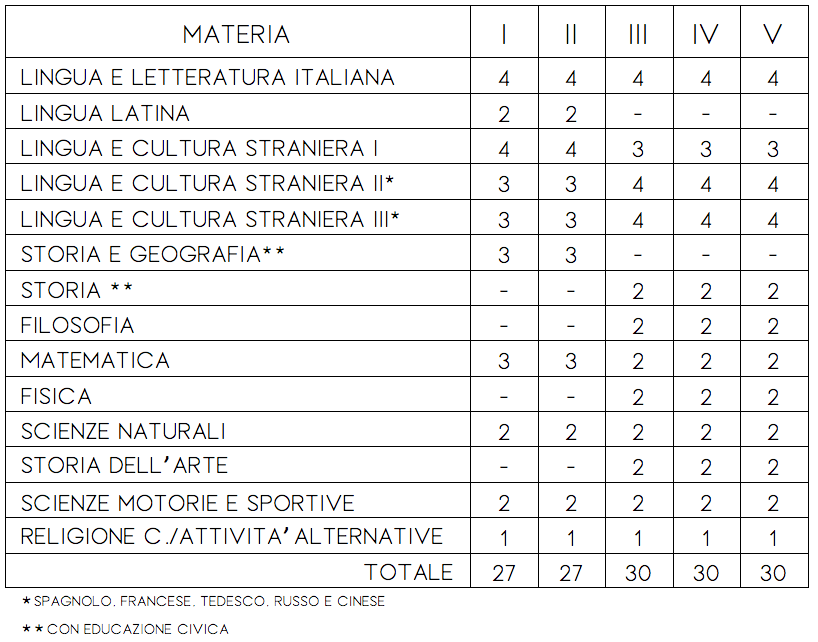
](https://www.istitutodantealighieri.it/wp-content/uploads/2023/01/quadro-LL-20-21.png)


Richieste specifiche:
- Nel quinto anno, le professoresse di Italiano e delle materie d'indirizzo (i.e. Inglese, Tedesco e Russo) hanno chiesto di ottenere uno slot da 3 ore, in un modo tale da consentire di svolgere delle esercitazioni della prima e seconda prova in vista della maturità.
- Inoltre, la professoressa di Storia e Filosofia ha chiesto di avere almeno uno slot da due ore, per delle motivazioni analoghe della prof. di Italiano.
- Tutte le classi hanno richiesto di avere le due ore di motoria attaccate, per evitare scomodità pratiche. 
- In vista agli esami di certificazioni delle lingue straniere Inglese e Tedesco, i professori hanno richiesto di ottenere almeno un slot da due ore per svolgere delle esercitazioni.

Vincoli specifici:
- Tutte le lezioni, tranne quelle di Motoria, saranno assegnate ad un'aula dedicata alla classe. Ad esempio, le lezioni di Italiano del 3° anno verranno assegnate solamente all'aula dedicata agli alunni del 3° anno.
- Esiste una sola aula per svolgere le lezioni di Motoria e quindi verrà condivisa tra le classi

In [23]:
import pandas as pd 
import numpy as np 
import itertools 
from model import TimetableScheduler
from z3 import *

In [24]:
liceo_timetable = TimetableScheduler('liceo', 5)

In [25]:
liceo_timetable.start()

In [26]:
liceo_timetable.add_constraints()

In [27]:
# Vincoli sulle aule

classi = liceo_timetable.indexes['CdS']
for classe in classi:
    corsi = liceo_timetable.database.get_courses(classe)
    for corso in corsi: 
        if corso in [1501, 2501, 3501]:
            continue # esclude motoria

        sessioni = liceo_timetable.database.get_sessions(corso)
        liceo_timetable.solver.add(
            And(
                [ Not(liceo_timetable.X[S, T, A]) for (S,T,A) in itertools.product(sessioni, liceo_timetable.T, liceo_timetable.indexes['Rooms']) if A != classe]
            
            )
        )
        

In [28]:
# Vincolo sulla palestra
sessioni_motoria = [
    i[0] for i in liceo_timetable.database.execute_query(
        """
            SELECT DISTINCT IDSession
            FROM Session
            WHERE IDCourse = 1501 OR IDCourse = 2501 OR IDCourse = 3501; 
        """
    )
]

liceo_timetable.solver.add(
    And(
        [Not(liceo_timetable.X[S, T, A]) for (S,T,A) in itertools.product(sessioni_motoria, liceo_timetable.T, liceo_timetable.indexes['Rooms']) if A in [1,2,3]]
    )
)

In [29]:
liceo_timetable.solver.set("timeout", 3000)

liceo_timetable.solve()
while not liceo_timetable.model:
    liceo_timetable.solve()
    print("Timed out, restarting...")

TIME TABLE SUCCESSFULLY CREATED
Saving the schedule in the SQL Database...
Schedule saved


In [30]:
# stampa l'orario per il liceo
names = liceo_timetable.database.get_names()
liceo_timeslots = []

for t in liceo_timetable.T:
    t_slots = []

    for (S, A) in itertools.product(liceo_timetable.indexes['Sessions'], liceo_timetable.indexes['Rooms']):
        S_c = liceo_timetable.database.get_course(S)
        if liceo_timetable.model.evaluate(liceo_timetable.X[S,t,A], model_completion=True):
            t_slots.append(f"{names['Courses'][liceo_timetable.database.get_course(S)]} [{names['Rooms'][A]}]")
                
    if t_slots == []:
        t_slots = ['NESSUNA LEZIONE']
    liceo_timeslots.append(" > " + "\n > ".join(t_slots))

In [31]:
rows = ["08:00-09:00","09:00-10:00","10:00-11:00","11:00-12:00","12:00-13:00"]
columns = ["Lunedì", "Martedì", "Mercoledì", "Giovedì", "Venerdì", "Sabato"]

np_liceo_timetable = np.array(liceo_timeslots, dtype=object)
np_liceo_timetable = np_liceo_timetable.reshape(6, 5)
df = pd.DataFrame(np_liceo_timetable, columns=rows, index=columns)

In [ ]:
from IPython.display import display, HTML 
display(HTML(df.T.to_html().replace("\\n", "<br>")))

,Lunedì,Martedì,Mercoledì,Giovedì,Venerdì,Sabato
08:00-09:00,> FILOSOFIA [ANNO III] > LINGUA E LETTERATURA ITALIANA [ANNO IV] > TERZA LINGUA STRANIERA (RUSSO) [ANNO V],> FILOSOFIA [ANNO III] > SCIENZE NATURALI [ANNO IV] > PRIMA LINGUA STRANIERA (INGLESE) [ANNO V],> STORIA DELL'ARTE [ANNO III] > RELIGIONE CATTOCIA O ATTIVITA' ALTERNATIVE [ANNO IV] > MATEMATICA [ANNO V],> SCIENZE NATURALI [ANNO III] > TERZA LINGUA STRANIERA (RUSSO) [ANNO IV] > LINGUA E LETTERATURA ITALIANA [ANNO V],> FISICA [ANNO III] > PRIMA LINGUA STRANIERA (INGLESE) [ANNO IV] > LINGUA E LETTERATURA ITALIANA [ANNO V],> TERZA LINGUA STRANIERA (RUSSO) [ANNO III] > STORIA DELL'ARTE [ANNO IV] > SECONDA LINGUA STRANIERA (TEDESCO) [ANNO V]
09:00-10:00,> RELIGIONE CATTOCIA O ATTIVITA' ALTERNATIVE [ANNO III] > LINGUA E LETTERATURA ITALIANA [ANNO IV] > TERZA LINGUA STRANIERA (RUSSO) [ANNO V],> SECONDA LINGUA STRANIERA (TEDESCO) [ANNO III] > SCIENZE E MOTORIE SPORTIVE (ANNO II) [PALESTRA] > PRIMA LINGUA STRANIERA (INGLESE) [ANNO V],> SCIENZE E MOTORIE SPORTIVE (ANNO I) [PALESTRA] > FILOSOFIA [ANNO IV] > SECONDA LINGUA STRANIERA (TEDESCO) [ANNO V],> TERZA LINGUA STRANIERA (RUSSO) [ANNO III] > SECONDA LINGUA STRANIERA (TEDESCO) [ANNO IV] > LINGUA E LETTERATURA ITALIANA [ANNO V],> STORIA DELL'ARTE [ANNO III] > SECONDA LINGUA STRANIERA (TEDESCO) [ANNO IV] > FISICA [ANNO V],> PRIMA LINGUA STRANIERA (INGLESE) [ANNO III] > SECONDA LINGUA STRANIERA (TEDESCO) [ANNO IV] > FILOSOFIA [ANNO V]
10:00-11:00,> LINGUA E LETTERATURA ITALIANA [ANNO III] > FISICA [ANNO IV] > TERZA LINGUA STRANIERA (RUSSO) [ANNO V],> SECONDA LINGUA STRANIERA (TEDESCO) [ANNO III] > SCIENZE E MOTORIE SPORTIVE (ANNO II) [PALESTRA] > PRIMA LINGUA STRANIERA (INGLESE) [ANNO V],> SCIENZE E MOTORIE SPORTIVE (ANNO I) [PALESTRA] > FISICA [ANNO IV] > SECONDA LINGUA STRANIERA (TEDESCO) [ANNO V],> TERZA LINGUA STRANIERA (RUSSO) [ANNO III] > MATEMATICA [ANNO IV] > LINGUA E LETTERATURA ITALIANA [ANNO V],> SECONDA LINGUA STRANIERA (TEDESCO) [ANNO III] > LINGUA E LETTERATURA ITALIANA [ANNO IV] > MATEMATICA [ANNO V],> PRIMA LINGUA STRANIERA (INGLESE) [ANNO III] > SECONDA LINGUA STRANIERA (TEDESCO) [ANNO IV] > SCIENZE NATURALI [ANNO V]
11:00-12:00,> LINGUA E LETTERATURA ITALIANA [ANNO III] > TERZA LINGUA STRANIERA (RUSSO) [ANNO IV] > STORIA [ANNO V],> STORIA [ANNO III] > PRIMA LINGUA STRANIERA (INGLESE) [ANNO IV] > SCIENZE E MOTORIE SPORTIVE (ANNO III) [PALESTRA],> LINGUA E LETTERATURA ITALIANA [ANNO III] > MATEMATICA [ANNO IV] > SECONDA LINGUA STRANIERA (TEDESCO) [ANNO V],> FISICA [ANNO III] > STORIA [ANNO IV] > RELIGIONE CATTOCIA O ATTIVITA' ALTERNATIVE [ANNO V],> MATEMATICA [ANNO III] > LINGUA E LETTERATURA ITALIANA [ANNO IV] > TERZA LINGUA STRANIERA (RUSSO) [ANNO V],> TERZA LINGUA STRANIERA (RUSSO) [ANNO III] > STORIA DELL'ARTE [ANNO IV] > FISICA [ANNO V]
12:00-13:00,> SECONDA LINGUA STRANIERA (TEDESCO) [ANNO III] > TERZA LINGUA STRANIERA (RUSSO) [ANNO IV] > STORIA [ANNO V],> STORIA [ANNO III] > PRIMA LINGUA STRANIERA (INGLESE) [ANNO IV] > SCIENZE E MOTORIE SPORTIVE (ANNO III) [PALESTRA],> LINGUA E LETTERATURA ITALIANA [ANNO III] > FILOSOFIA [ANNO IV] > STORIA DELL'ARTE [ANNO V],> SCIENZE NATURALI [ANNO III] > TERZA LINGUA STRANIERA (RUSSO) [ANNO IV] > FILOSOFIA [ANNO V],> MATEMATICA [ANNO III] > STORIA [ANNO IV] > SCIENZE NATURALI [ANNO V],> PRIMA LINGUA STRANIERA (INGLESE) [ANNO III] > SCIENZE NATURALI [ANNO IV] > STORIA DELL'ARTE [ANNO V]


In [33]:
liceo_timetable.end()

Fine della demo